### Лабораторная работа №4
####  Исследование абсолютно-оптимальных рекуррентных алгоритмов

Для оценки эффективности абсолютно-оптимальных алгоритмов рассмотрим задачу идентификации параметров линейного регрессионного объекта вида:
\begin{equation}y(i)=с_{0}+с_{1}u_{1}(i)+...+с_{4}u_{4}(i)+\eta(i)\end{equation}

Пусть шум измерений $\eta(i)$ имеет распределение Коши:
\begin{equation*}
f(\eta)=\frac{1}{\pi s}\frac{1}{(1+(\eta/s)^2)}
\end{equation*}

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# параметры объекта 
c0=2
c1=4
c2=7
c3=3
c4=5
c = np.array([c0, c1, c2, c3, c4])

In [3]:
# количество измерений
N=200

In [4]:
np.random.seed(42)

In [5]:
# параметр распределения Коши
s=0.1
s12=2
s13=10

In [6]:
Noise=st.cauchy.rvs(loc=0, scale=s, size=N)
Noise12=st.cauchy.rvs(loc=0, scale=s12, size=N)
Noise13=st.cauchy.rvs(loc=0, scale=s13, size=N)

In [7]:
# Avg_U0=1
# Var_U0=50
Avg_U1=1
Var_U1=50
Avg_U2=1
Var_U2=50
Avg_U3=1
Var_U3=50
Avg_U4=1
Var_U4=50

In [8]:
# моделирование входов объекта
U0 = np.array([1]*N)
U1=np.random.normal(Avg_U1,Var_U1,size=N)
U2=np.random.normal(Avg_U2,Var_U2,size=N)
U3=np.random.normal(Avg_U3,Var_U3,size=N)
U4=np.random.normal(Avg_U4,Var_U4,size=N)

In [32]:
# моделирование выхода объекта
y=c0*U0+c1*U1+c2*U2+c3*U3+c4*U4+Noise
y12=c0*U0+c1*U1+c2*U2+c3*U3+c4*U4+Noise12
y13=c0*U0+c1*U1+c2*U2+c3*U3+c4*U4+Noise13
print(y[49], y12[49])
# print(y[199], y12[199])
print(Noise13[131])
print(Noise12[131])
print(Noise[131])

-202.6496212859383 -198.47853238407038
11274.51945126959
2.1011098969611255
-0.11926238978483848


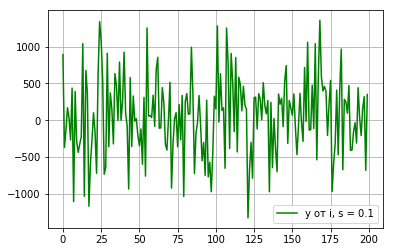

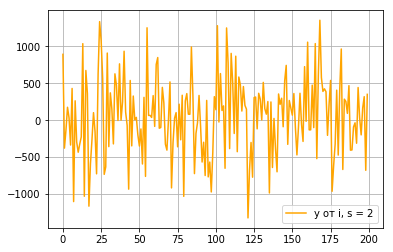

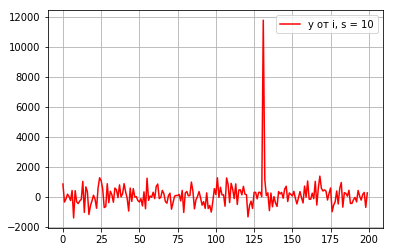

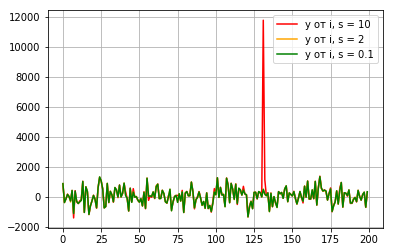

In [10]:
# plt.plot(y)
# plt.show()
# plt.plot(y12)
# plt.show()
# plt.plot(y13)
# plt.show()

fig, ax = plt.subplots()  
plt.plot(y, color="green", label="y от i, s = 0.1")
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('plot1_y01.pdf')

fig, ax = plt.subplots()  
plt.plot(y12, color="orange", label="y от i, s = 2")
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('plot1_y2.pdf')

fig, ax = plt.subplots()  
plt.plot(y13, color="red", label="y от i, s = 10")
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('plot1_y10.pdf')

fig, ax = plt.subplots()  
plt.plot(y13, color="red", label="y от i, s = 10")
plt.plot(y12, color="orange", label="y от i, s = 2")
plt.plot(y, color="green", label="y от i, s = 0.1")
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('plot1_all_y.pdf')

#### Формирование алгоритма идентификации

В зависимости от того, насколько хорошо изучен «объект» идентификации, могут возникнуть следующие ситуации:

1. Объект изучен хорошо, правильно определена плотность распределения шума, т.е. принятая и реальная плотности распределения совпадают и на основе принятой функции распределения формируется оптимальная функция потерь.


2. Объект изучен плохо. При этом, как правило, считают, что плотность распределения шума соответствует нормальному закону распределения, хотя на самом деле(в данном случаем, см. описание объекта выше) шум имеет распределение Коши. Таким образом, опираясь на ложную гипотезу о нормальном распределении шума, в качестве функции потерь выбирается квадратичная функция.

Предлагается реализовать абсолютно-оптимальный рекуррентный алгоритм оценивания параметров объекта для каждой из ситуаций. Для   оценки   эффективности использования абсолютно-оптимальных  рекуррентных  алгоритмов  проводилось сравнение сглаженной ошибки оценки параметров объекта,определенных когда объект изучили хорошо и когда плохо, при  различных  значениях  параметра  распределения Коши — s.

#### В первом случае рекуррентный алгоритм принимает вид:
\begin{equation}\hat{\vec{c}}(i)=\hat{\vec{c}}(i-1)+Г(i)\frac{2(y(i)-\hat{c}_{0}(i-1)u_{0}(i)-...-\hat{c}_{4}(i-1)u_{4}(i))}{s^2+(y(i)-\hat{c}_{0}(i-1)u_{0}(i)-...-\hat{c}_{4}(i-1)u_{4}(i))^2}\vec{z}(i) \\
Г(i)=Г(i-1)-\frac{Г(i-1)\vec{z}(i)\vec{z}(i)^TГ(i-1)}{2s^2+\vec{z}^T(i)Г(i-1)\vec{z}(i)} \\
Г(0)=\lambda I, \lambda=0.1\\
\hat{\vec{c}}(0)=\vec{c}_{0}\end{equation}

In [28]:
#Обозначение переменных
flag = 1
i = 1
c = np.array([[c0], [c1], [c2], [c3], [c4]])
c_1 = [[0]*5]*N
c_12 = [[0]*5]*N
c_13 = [[0]*5]*N
U = np.array([[U0], [U1], [U2], [U3], [U4]])
z = U.transpose()
lamb = 0.1
Г_0 = np.eye(5)*lamb
Гi_1 = Г_0
# c = np.array([[1.5], [4.5], [6.5], [1.5], [5.5]])
# c = np.array([[3], [3], [6], [4], [4]])
c = np.array([[1.9], [3.9], [6.9], [2.9], [4.9]])
c_1[0] = c
c_12[0] = c
c_13[0] = c



#Реализация итераций для матрицы Г и c
s=0.1
eps = 0
while True:
    #матрица Г
    ziT = z[i].transpose()
    
    num = ((Гi_1.dot(ziT)).dot((z[i]))).dot(Гi_1)

    denum = 2*s*s+((z[i]).dot(Гi_1)).dot(ziT)

    Гi = Гi_1 - num/denum
    Гi_1 = Гi
    
    #Параметр С
    eps = y[i] - (z[i]).dot(c)
    num = 2 * eps
    denum = s * s + eps * eps
    ci = c + (Гi*(num/denum)).dot(ziT)
    c = ci
    c_1[i] = c
    print(i)
    i = i + 1
    

    if i==N:
        break

c_1 = np.array(c_1)
print(c_1)


# s=2
eps = 0
# c = np.array([[3], [3], [6], [4], [4]])
c = np.array([[1.9], [3.9], [6.9], [2.9], [4.9]])
i = 1
Гi_1 = Г_0
while True:
    #матрица Г
    ziT = z[i].transpose()
    
    num = ((Гi_1.dot(ziT)).dot((z[i]))).dot(Гi_1)

    denum = 2*s12*s12+((z[i]).dot(Гi_1)).dot(ziT)

    Гi = Гi_1 - num/denum
    Гi_1 = Гi
    
    #Параметр С
    eps = y12[i] - (z[i]).dot(c)
    num = 2 * eps
    denum = s12 * s12 + eps * eps
    ci = c + (Гi*(num/denum)).dot(ziT)
    c = ci
    c_12[i] = c
    i = i + 1
    

    if i==N:
        break

c_12 = np.array(c_12)
print(c_12)
        

# s=10
eps = 0
# c = np.array([[3], [3], [6], [4], [4]])
c = np.array([[1.9], [3.9], [6.9], [2.9], [4.9]])
i = 1
Гi_1 = Г_0
while True:
    #матрица Г
    ziT = z[i].transpose()
    
    num = ((Гi_1.dot(ziT)).dot((z[i]))).dot(Гi_1)

    denum = 2*s13*s13+((z[i]).dot(Гi_1)).dot(ziT)
    if i == 49:
        print(num,denum)
    Гi = Гi_1 - num/denum
    Гi_1 = Гi
    
    #Параметр С
    eps = y13[i] - (z[i]).dot(c)
    num = 2 * eps
    denum = s13 * s13 + eps * eps
    ci = c + (Гi*(num/denum)).dot(ziT)
    c = ci
    c_13[i] = c
    i = i + 1
    
    if i == 49:
        print(num,denum)
    if i==N:
        break

c_13 = np.array(c_13)
print(c_13)      

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
[[[1.9       ]
  [3.9       ]
  [6.9       ]
  [2.9       ]
  [4.9       ]]

 [[1.89999863]
  [3.90005311]
  [6.89999456]
  [2.90003784]
  [4.90004477]]

 [[1.8999936 ]
  [3.89996414]
  [6.89999335]
  [2.90028423]
  [4.89994177]]

 [[1.89999629]
  [3.89986686]
  [6.89999452]
  [2.90029404]
  [4.90004909]]

 [[1

#### Во втором случае рекуррентный алгоритм принимает вид:
\begin{equation}\hat{\vec{c}}(i)=\hat{\vec{c}}(i-1)+Г(i)\vec{z}(i)(y(i)-\hat{c}_{0}(i-1)u_{0}(i)-...-\hat{c}_{4}(i-1)u_{4}(i)) \\
Г(i)=Г(i-1)-\frac{Г(i-1)\vec{z}(i)\vec{z}(i)^TГ(i-1)}{1+\vec{z}^T(i)Г(i-1)\vec{z}(i)} \\
Г(0)=\lambda I , \lambda=0.1    \\
\hat{\vec{c}}(0)=\vec{c}_{0}\end{equation}

In [29]:
#Обозначение переменных
flag = 1
i = 1
c = np.array([[c0], [c1], [c2], [c3], [c4]])
c_2 = [[0]*5]*N
c_22 = [[0]*5]*N
c_23 = [[0]*5]*N
U = np.array([[U0], [U1], [U2], [U3], [U4]])
z = U.transpose()
lamb = 0.1
Г_0 = np.eye(5)*lamb
Гi_1 = Г_0
# c = np.array([[1.5], [4.5], [6.5], [1.5], [5.5]])
# c = np.array([[3], [3], [6], [4], [4]])
c = np.array([[1.9], [3.9], [6.9], [2.9], [4.9]])
c_2[0] = c
c_22[0] = c
c_23[0] = c


#s=10
c = np.array([[1.9], [3.9], [6.9], [2.9], [4.9]])
# c = np.array([[3], [3], [6], [4], [4]])
i = 0
Гi_1 = Г_0
eps = 0
num = 0
denum = 0
while True:
    ziT = z[i].transpose()
    #матрица Г
    num = ((Гi_1.dot(ziT)).dot((z[i]))).dot(Гi_1)

    denum = 1+((z[i]).dot(Гi_1)).dot(ziT)
    Гi = Гi_1 - num/denum
    Гi_1 = Гi
    if i == 49:
        print(num,denum)
    #Параметр С
#     print('y[i]=',y[i])
    eps = y13[i] - (z[i]).dot(c)
    ci = c + (Гi).dot(ziT)*eps
    c = ci
    c_23[i] = c
    i = i + 1
    
    if i==N:
        break
    
c_23 = np.array(c_23)
print('\nC_23\n',c_23)


#Реализация итераций для матрицы Г и c
i = 1
Гi_1 = Г_0
eps = 0
eps = 0
num = 0
denum = 0
c = np.array([[1.9], [3.9], [6.9], [2.9], [4.9]])
# c = np.array([[3], [3], [6], [4], [4]])
while True:
    ziT = z[i].transpose()
    #матрица Г
    num = ((Гi_1.dot(ziT)).dot((z[i]))).dot(Гi_1)

    denum = 1+((z[i]).dot(Гi_1)).dot(ziT)
    Гi = Гi_1 - num/denum
    Гi_1 = Гi
    if i == 49:
        print(num,denum)
    #Параметр С
#     print('y[i]=',y[i])
    eps = y[i] - (z[i]).dot(c)
    ci = c + (Гi).dot(ziT)*eps
    c = ci
    c_2[i] = c
    i = i + 1
    
    if i==N:
        break
    
c_2 = np.array(c_2)
print('\nC_2\n',c_2)

#s=2
eps = 0
num = 0
denum = 0
c = np.array([[1.9], [3.9], [6.9], [2.9], [4.9]])
# c = np.array([[3], [3], [6], [4], [4]])
i = 1
Гi_1 = Г_0
while True:
    ziT = z[i].transpose()
    #матрица Г
    num = ((Гi_1.dot(ziT)).dot((z[i]))).dot(Гi_1)

    denum = 1+((z[i]).dot(Гi_1)).dot(ziT)
    Гi = Гi_1 - num/denum
    Гi_1 = Гi
    if i == 49:
        print(num,denum)
    #Параметр С
#     print('y[i]=',y[i])
    eps = y12[i] - (z[i]).dot(c)
    ci = c + (Гi).dot(ziT)*eps
    c = ci
    c_22[i] = c
    i = i + 1
    
    if i==N:
        break
    
c_22 = np.array(c_22)
print('\nC_22\n',c_22)




[[ 3.24931491e-05  1.94776732e-06 -5.05389895e-06  4.24694667e-06
  -5.59736304e-07]
 [ 1.94776732e-06  1.16756844e-07 -3.02950606e-07  2.54578709e-07
  -3.35527984e-08]
 [-5.05389895e-06 -3.02950606e-07  7.86070151e-07 -6.60558916e-07
   8.70599126e-08]
 [ 4.24694667e-06  2.54578709e-07 -6.60558916e-07  5.55087966e-07
  -7.31591213e-08]
 [-5.59736304e-07 -3.35527984e-08  8.70599126e-08 -7.31591213e-08
   9.64217809e-09]] [[1.12616835]]

C_23
 [[[ 1.89937035e+00]
  [ 3.91606425e+00]
  [ 6.81835423e+00]
  [ 2.85464915e+00]
  [ 4.91669540e+00]]

 [[ 1.90600901e+00]
  [ 3.65807715e+00]
  [ 6.83081534e+00]
  [ 2.66088135e+00]
  [ 4.69973250e+00]]

 [[ 1.89363249e+00]
  [ 3.51490616e+00]
  [ 6.56541755e+00]
  [ 3.02607798e+00]
  [ 4.53038691e+00]]

 [[ 1.89797459e+00]
  [ 3.35312804e+00]
  [ 6.56081162e+00]
  [ 3.04242044e+00]
  [ 4.70806157e+00]]

 [[ 2.10577494e+00]
  [ 3.34008480e+00]
  [ 6.47801475e+00]
  [ 3.14816514e+00]
  [ 4.62082078e+00]]

 [[ 1.74461961e+00]
  [ 3.51191274e+00]
  

Сглаженная ошибка оценки вычисляется по формуле:
\begin{equation*}
err_{сгл}=\sqrt{\frac{\sum_{j=1}^{10}\sum_{k=0}^4(\hat{c}_{k}(i-j)-c_{k})^2}{10}} ; i=10,11,12...
\end{equation*}

In [33]:
# err_1 = np.array([]*N)
#----==-----S = 0.1--==----==--
err_1 = [0]*(N-9)
# c = np.array([[3], [3], [6], [4], [4]])
c = np.array([[1.9], [3.9], [6.9], [2.9], [4.9]])
for i in range(10,N+1):
    print('i=',i)
    for j in range(1,11):
        print('j=',j)
        print('pod kornem =',(((c_1[i-j][0]-c[0])**2 + (c_1[i-j][1]-c[1])**2 + (c_1[i-j][2]-c[2])**2 + (c_1[i-j][3]-c[3])**2 + (c_1[i-j][4]-c[4])**2)**(1/2)))
        err_1[i-10] = err_1[i-10] + ((c_1[i-j][0]-c[0])**2 + (c_1[i-j][1]-c[1])**2 + (c_1[i-j][2]-c[2])**2 + (c_1[i-j][3]-c[3])**2 + (c_1[i-j][4]-c[4])**2)
        print('err_1[i-10]=',err_1[i-10])
    err_1[i-10] = (err_1[i-10]/10)**(1/2)
err_1 = np.array(err_1)
print(len(err_1), err_1,'----==-----==----==------==--')
#----==-----==----==------===--

#----==-----S = 2--==----==--
err_12 = [0]*(N-9)
for i in range(10,N+1):
    print('i=',i)
    for j in range(1,11):
        print('j=',j)
        print('pod kornem =',(((c_12[i-j][0]-c[0])**2 + (c_12[i-j][1]-c[1])**2 + (c_12[i-j][2]-c[2])**2 + (c_12[i-j][3]-c[3])**2 + (c_12[i-j][4]-c[4])**2)**(1/2)))
        err_12[i-10] = err_12[i-10] + ((c_12[i-j][0]-c[0])**2 + (c_12[i-j][1]-c[1])**2 + (c_12[i-j][2]-c[2])**2 + (c_12[i-j][3]-c[3])**2 + (c_12[i-j][4]-c[4])**2)
        print('err_12[i-10]=',err_12[i-10])
    err_12[i-10] = (err_12[i-10]/10)**(1/2)
err_12 = np.array(err_12)
print(len(err_12), err_12,'----==-----==----==------==--')
#----==-----==----==------===--


#----==-----S = 10--==----==--
err_13 = [0]*(N-9)
for i in range(10,N+1):
    print('i=',i)
    for j in range(1,11):
        print('j=',j)
        print('pod kornem =',(((c_13[i-j][0]-c[0])**2 + (c_13[i-j][1]-c[1])**2 + (c_13[i-j][2]-c[2])**2 + (c_13[i-j][3]-c[3])**2 + (c_13[i-j][4]-c[4])**2)**(1/2)))
        err_13[i-10] = err_13[i-10] + ((c_13[i-j][0]-c[0])**2 + (c_13[i-j][1]-c[1])**2 + (c_13[i-j][2]-c[2])**2 + (c_13[i-j][3]-c[3])**2 + (c_13[i-j][4]-c[4])**2)
        print('err_13[i-10]=',err_13[i-10])
    err_13[i-10] = (err_13[i-10]/10)**(1/2)
err_13 = np.array(err_13)
print(len(err_13), err_13, '----==-----==----==------==--')
#----==-----==----==------===--

#----==-----S = 0.1--==----==--
err_2 = [0]*(N-9)
for i in range(10,N+1):
    print('i=',i)
    for j in range(1,11):
        print('j=',j)
        print('pod kornem =',(((c_2[i-j][0]-c[0])**2 + (c_2[i-j][1]-c[1])**2 + (c_2[i-j][2]-c[2])**2 + (c_2[i-j][3]-c[3])**2 + (c_2[i-j][4]-c[4])**2)**(1/2)))
        err_2[i-10] = err_2[i-10] + ((c_2[i-j][0]-c[0])**2 + (c_2[i-j][1]-c[1])**2 + (c_2[i-j][2]-c[2])**2 + (c_2[i-j][3]-c[3])**2 + (c_2[i-j][4]-c[4])**2)
        print('err_2[i-10]=',err_2[i-10])
    err_2[i-10] = (err_2[i-10]/10)**(1/2)
err_2 = np.array(err_2)
print(len(err_2), err_2,'----==-----==----==------==--')
#----==-----==----==------===--


#----==-----S = 2--==----==--
err_22 = [0]*(N-9)
for i in range(10,N+1):
    print('i=',i)
    for j in range(1,11):
        print('j=',j)
        print('pod kornem =',(((c_22[i-j][0]-c[0])**2 + (c_22[i-j][1]-c[1])**2 + (c_22[i-j][2]-c[2])**2 + (c_22[i-j][3]-c[3])**2 + (c_22[i-j][4]-c[4])**2)**(1/2)))
        err_22[i-10] = err_22[i-10] + ((c_22[i-j][0]-c[0])**2 + (c_22[i-j][1]-c[1])**2 + (c_22[i-j][2]-c[2])**2 + (c_22[i-j][3]-c[3])**2 + (c_22[i-j][4]-c[4])**2)
        print('err_22[i-10]=',err_22[i-10])
    err_22[i-10] = (err_22[i-10]/10)**(1/2)
err_22 = np.array(err_22)
print(len(err_22), err_22,'----==-----==----==------==--')
#----==-----==----==------===--

#----==-----S = 10--==----==--
err_23 = [0]*(N-9)
for i in range(10,N+1):
    print('i=',i)
    for j in range(1,11):
        print('j=',j)
        print('pod kornem =',(((c_23[i-j][0]-c[0])**2 + (c_23[i-j][1]-c[1])**2 + (c_23[i-j][2]-c[2])**2 + (c_23[i-j][3]-c[3])**2 + (c_23[i-j][4]-c[4])**2)**(1/2)))
        err_23[i-10] = err_23[i-10] + ((c_23[i-j][0]-c[0])**2 + (c_23[i-j][1]-c[1])**2 + (c_23[i-j][2]-c[2])**2 + (c_23[i-j][3]-c[3])**2 + (c_23[i-j][4]-c[4])**2)
        print('err_23[i-10]=',err_23[i-10])
    err_23[i-10] = (err_23[i-10]/10)**(1/2)
err_23 = np.array(err_23)
print(len(err_23), err_23,'----==-----==----==------==--')
#----==-----==----==------===--

i= 10
j= 1
pod kornem = [0.00999066]
err_1[i-10]= [9.98133052e-05]
j= 2
pod kornem = [0.00287607]
err_1[i-10]= [0.00010809]
j= 3
pod kornem = [0.0036229]
err_1[i-10]= [0.00012121]
j= 4
pod kornem = [0.00390682]
err_1[i-10]= [0.00013647]
j= 5
pod kornem = [0.00445945]
err_1[i-10]= [0.00015636]
j= 6
pod kornem = [0.00279964]
err_1[i-10]= [0.0001642]
j= 7
pod kornem = [0.00032656]
err_1[i-10]= [0.00016431]
j= 8
pod kornem = [0.00029249]
err_1[i-10]= [0.00016439]
j= 9
pod kornem = [7.93013428e-05]
err_1[i-10]= [0.0001644]
j= 10
pod kornem = [0.]
err_1[i-10]= [0.0001644]
i= 11
j= 1
pod kornem = [0.00934441]
err_1[i-10]= [8.73180449e-05]
j= 2
pod kornem = [0.00999066]
err_1[i-10]= [0.00018713]
j= 3
pod kornem = [0.00287607]
err_1[i-10]= [0.0001954]
j= 4
pod kornem = [0.0036229]
err_1[i-10]= [0.00020853]
j= 5
pod kornem = [0.00390682]
err_1[i-10]= [0.00022379]
j= 6
pod kornem = [0.00445945]
err_1[i-10]= [0.00024368]
j= 7
pod kornem = [0.00279964]
err_1[i-10]= [0.00025152]
j= 8
pod kornem = [0

err_1[i-10]= [0.00072514]
j= 7
pod kornem = [0.0113421]
err_1[i-10]= [0.00085378]
j= 8
pod kornem = [0.01143586]
err_1[i-10]= [0.00098456]
j= 9
pod kornem = [0.01123514]
err_1[i-10]= [0.00111079]
j= 10
pod kornem = [0.01130722]
err_1[i-10]= [0.00123864]
i= 39
j= 1
pod kornem = [0.0105651]
err_1[i-10]= [0.00011162]
j= 2
pod kornem = [0.0106795]
err_1[i-10]= [0.00022567]
j= 3
pod kornem = [0.01074981]
err_1[i-10]= [0.00034123]
j= 4
pod kornem = [0.01108325]
err_1[i-10]= [0.00046407]
j= 5
pod kornem = [0.01115443]
err_1[i-10]= [0.00058849]
j= 6
pod kornem = [0.01123302]
err_1[i-10]= [0.00071467]
j= 7
pod kornem = [0.01104938]
err_1[i-10]= [0.00083676]
j= 8
pod kornem = [0.0113421]
err_1[i-10]= [0.0009654]
j= 9
pod kornem = [0.01143586]
err_1[i-10]= [0.00109618]
j= 10
pod kornem = [0.01123514]
err_1[i-10]= [0.00122241]
i= 40
j= 1
pod kornem = [0.01043001]
err_1[i-10]= [0.00010879]
j= 2
pod kornem = [0.0105651]
err_1[i-10]= [0.00022041]
j= 3
pod kornem = [0.0106795]
err_1[i-10]= [0.00033446

err_1[i-10]= [0.00021617]
j= 9
pod kornem = [0.00479162]
err_1[i-10]= [0.00023913]
j= 10
pod kornem = [0.00481465]
err_1[i-10]= [0.00026231]
i= 69
j= 1
pod kornem = [0.00546513]
err_1[i-10]= [2.98676293e-05]
j= 2
pod kornem = [0.00541495]
err_1[i-10]= [5.918929e-05]
j= 3
pod kornem = [0.00529509]
err_1[i-10]= [8.72273079e-05]
j= 4
pod kornem = [0.00535441]
err_1[i-10]= [0.0001159]
j= 5
pod kornem = [0.00540403]
err_1[i-10]= [0.0001451]
j= 6
pod kornem = [0.00511883]
err_1[i-10]= [0.0001713]
j= 7
pod kornem = [0.00496015]
err_1[i-10]= [0.00019591]
j= 8
pod kornem = [0.00498295]
err_1[i-10]= [0.00022074]
j= 9
pod kornem = [0.00502978]
err_1[i-10]= [0.00024603]
j= 10
pod kornem = [0.00479162]
err_1[i-10]= [0.00026899]
i= 70
j= 1
pod kornem = [0.00407317]
err_1[i-10]= [1.65906831e-05]
j= 2
pod kornem = [0.00546513]
err_1[i-10]= [4.64583124e-05]
j= 3
pod kornem = [0.00541495]
err_1[i-10]= [7.57799731e-05]
j= 4
pod kornem = [0.00529509]
err_1[i-10]= [0.00010382]
j= 5
pod kornem = [0.00535441

i= 95
j= 1
pod kornem = [0.00349009]
err_1[i-10]= [1.21807614e-05]
j= 2
pod kornem = [0.00349553]
err_1[i-10]= [2.4399513e-05]
j= 3
pod kornem = [0.00349136]
err_1[i-10]= [3.65890729e-05]
j= 4
pod kornem = [0.00348169]
err_1[i-10]= [4.87112558e-05]
j= 5
pod kornem = [0.00347827]
err_1[i-10]= [6.08096145e-05]
j= 6
pod kornem = [0.00346527]
err_1[i-10]= [7.28177347e-05]
j= 7
pod kornem = [0.00346871]
err_1[i-10]= [8.48496663e-05]
j= 8
pod kornem = [0.00347866]
err_1[i-10]= [9.69507195e-05]
j= 9
pod kornem = [0.00348743]
err_1[i-10]= [0.00010911]
j= 10
pod kornem = [0.00348873]
err_1[i-10]= [0.00012128]
i= 96
j= 1
pod kornem = [0.00349234]
err_1[i-10]= [1.21964353e-05]
j= 2
pod kornem = [0.00349009]
err_1[i-10]= [2.43771967e-05]
j= 3
pod kornem = [0.00349553]
err_1[i-10]= [3.65959483e-05]
j= 4
pod kornem = [0.00349136]
err_1[i-10]= [4.87855082e-05]
j= 5
pod kornem = [0.00348169]
err_1[i-10]= [6.09076911e-05]
j= 6
pod kornem = [0.00347827]
err_1[i-10]= [7.30060498e-05]
j= 7
pod kornem = [0

pod kornem = [0.00345992]
err_1[i-10]= [8.42393024e-05]
j= 8
pod kornem = [0.00347631]
err_1[i-10]= [9.63240399e-05]
j= 9
pod kornem = [0.00347939]
err_1[i-10]= [0.00010843]
j= 10
pod kornem = [0.00349193]
err_1[i-10]= [0.00012062]
i= 127
j= 1
pod kornem = [0.00347228]
err_1[i-10]= [1.20567557e-05]
j= 2
pod kornem = [0.00346846]
err_1[i-10]= [2.40869716e-05]
j= 3
pod kornem = [0.0034646]
err_1[i-10]= [3.60904082e-05]
j= 4
pod kornem = [0.00346625]
err_1[i-10]= [4.81052798e-05]
j= 5
pod kornem = [0.00347143]
err_1[i-10]= [6.01560774e-05]
j= 6
pod kornem = [0.00347533]
err_1[i-10]= [7.22339991e-05]
j= 7
pod kornem = [0.00347721]
err_1[i-10]= [8.43249801e-05]
j= 8
pod kornem = [0.00345992]
err_1[i-10]= [9.62960581e-05]
j= 9
pod kornem = [0.00347631]
err_1[i-10]= [0.00010838]
j= 10
pod kornem = [0.00347939]
err_1[i-10]= [0.00012049]
i= 128
j= 1
pod kornem = [0.00352827]
err_1[i-10]= [1.24487023e-05]
j= 2
pod kornem = [0.00347228]
err_1[i-10]= [2.4505458e-05]
j= 3
pod kornem = [0.00346846]


pod kornem = [0.00398968]
err_1[i-10]= [8.02051224e-05]
j= 6
pod kornem = [0.00398276]
err_1[i-10]= [9.60674599e-05]
j= 7
pod kornem = [0.00397181]
err_1[i-10]= [0.00011184]
j= 8
pod kornem = [0.00401569]
err_1[i-10]= [0.00012797]
j= 9
pod kornem = [0.00399197]
err_1[i-10]= [0.0001439]
j= 10
pod kornem = [0.00397872]
err_1[i-10]= [0.00015973]
i= 152
j= 1
pod kornem = [0.00406971]
err_1[i-10]= [1.65625421e-05]
j= 2
pod kornem = [0.0040559]
err_1[i-10]= [3.30128661e-05]
j= 3
pod kornem = [0.00402666]
err_1[i-10]= [4.92268424e-05]
j= 4
pod kornem = [0.00398915]
err_1[i-10]= [6.51401694e-05]
j= 5
pod kornem = [0.00396357]
err_1[i-10]= [8.08500805e-05]
j= 6
pod kornem = [0.00398968]
err_1[i-10]= [9.67676645e-05]
j= 7
pod kornem = [0.00398276]
err_1[i-10]= [0.00011263]
j= 8
pod kornem = [0.00397181]
err_1[i-10]= [0.00012841]
j= 9
pod kornem = [0.00401569]
err_1[i-10]= [0.00014453]
j= 10
pod kornem = [0.00399197]
err_1[i-10]= [0.00016047]
i= 153
j= 1
pod kornem = [0.00398825]
err_1[i-10]= [1.

err_1[i-10]= [0.00011189]
j= 8
pod kornem = [0.0040369]
err_1[i-10]= [0.00012819]
j= 9
pod kornem = [0.00402402]
err_1[i-10]= [0.00014438]
j= 10
pod kornem = [0.00400842]
err_1[i-10]= [0.00016045]
i= 184
j= 1
pod kornem = [0.00398539]
err_1[i-10]= [1.58833087e-05]
j= 2
pod kornem = [0.00399579]
err_1[i-10]= [3.18496857e-05]
j= 3
pod kornem = [0.00398769]
err_1[i-10]= [4.77513237e-05]
j= 4
pod kornem = [0.00398073]
err_1[i-10]= [6.35974983e-05]
j= 5
pod kornem = [0.00399215]
err_1[i-10]= [7.95347594e-05]
j= 6
pod kornem = [0.00398406]
err_1[i-10]= [9.54075209e-05]
j= 7
pod kornem = [0.00401581]
err_1[i-10]= [0.00011153]
j= 8
pod kornem = [0.00402999]
err_1[i-10]= [0.00012778]
j= 9
pod kornem = [0.0040369]
err_1[i-10]= [0.00014407]
j= 10
pod kornem = [0.00402402]
err_1[i-10]= [0.00016026]
i= 185
j= 1
pod kornem = [0.00401859]
err_1[i-10]= [1.6149073e-05]
j= 2
pod kornem = [0.00398539]
err_1[i-10]= [3.20323817e-05]
j= 3
pod kornem = [0.00399579]
err_1[i-10]= [4.79987588e-05]
j= 4
pod korn

j= 10
pod kornem = [0.06121423]
err_12[i-10]= [0.06339703]
i= 25
j= 1
pod kornem = [0.11398507]
err_12[i-10]= [0.0129926]
j= 2
pod kornem = [0.10740748]
err_12[i-10]= [0.02452896]
j= 3
pod kornem = [0.08371195]
err_12[i-10]= [0.03153666]
j= 4
pod kornem = [0.08735594]
err_12[i-10]= [0.03916772]
j= 5
pod kornem = [0.09192594]
err_12[i-10]= [0.04761809]
j= 6
pod kornem = [0.08124802]
err_12[i-10]= [0.05421933]
j= 7
pod kornem = [0.06796297]
err_12[i-10]= [0.0588383]
j= 8
pod kornem = [0.06953421]
err_12[i-10]= [0.06367331]
j= 9
pod kornem = [0.07023501]
err_12[i-10]= [0.06860626]
j= 10
pod kornem = [0.063531]
err_12[i-10]= [0.07264245]
i= 26
j= 1
pod kornem = [0.12295439]
err_12[i-10]= [0.01511778]
j= 2
pod kornem = [0.11398507]
err_12[i-10]= [0.02811038]
j= 3
pod kornem = [0.10740748]
err_12[i-10]= [0.03964675]
j= 4
pod kornem = [0.08371195]
err_12[i-10]= [0.04665444]
j= 5
pod kornem = [0.08735594]
err_12[i-10]= [0.0542855]
j= 6
pod kornem = [0.09192594]
err_12[i-10]= [0.06273588]
j= 7


j= 2
pod kornem = [0.10945415]
err_12[i-10]= [0.02630346]
j= 3
pod kornem = [0.10603647]
err_12[i-10]= [0.03754719]
j= 4
pod kornem = [0.10867092]
err_12[i-10]= [0.04935656]
j= 5
pod kornem = [0.13144567]
err_12[i-10]= [0.06663453]
j= 6
pod kornem = [0.16172074]
err_12[i-10]= [0.09278812]
j= 7
pod kornem = [0.18279494]
err_12[i-10]= [0.12620212]
j= 8
pod kornem = [0.19747184]
err_12[i-10]= [0.16519724]
j= 9
pod kornem = [0.19329708]
err_12[i-10]= [0.202561]
j= 10
pod kornem = [0.18591075]
err_12[i-10]= [0.23712381]
i= 58
j= 1
pod kornem = [0.14263499]
err_12[i-10]= [0.02034474]
j= 2
pod kornem = [0.11967978]
err_12[i-10]= [0.03466799]
j= 3
pod kornem = [0.10945415]
err_12[i-10]= [0.0466482]
j= 4
pod kornem = [0.10603647]
err_12[i-10]= [0.05789193]
j= 5
pod kornem = [0.10867092]
err_12[i-10]= [0.0697013]
j= 6
pod kornem = [0.13144567]
err_12[i-10]= [0.08697927]
j= 7
pod kornem = [0.16172074]
err_12[i-10]= [0.11313287]
j= 8
pod kornem = [0.18279494]
err_12[i-10]= [0.14654686]
j= 9
pod ko

err_12[i-10]= [0.07016823]
j= 5
pod kornem = [0.15219565]
err_12[i-10]= [0.09333175]
j= 6
pod kornem = [0.14413487]
err_12[i-10]= [0.11410661]
j= 7
pod kornem = [0.15530695]
err_12[i-10]= [0.13822686]
j= 8
pod kornem = [0.17976602]
err_12[i-10]= [0.17054268]
j= 9
pod kornem = [0.15401299]
err_12[i-10]= [0.19426268]
j= 10
pod kornem = [0.14126923]
err_12[i-10]= [0.21421968]
i= 90
j= 1
pod kornem = [0.1394063]
err_12[i-10]= [0.01943412]
j= 2
pod kornem = [0.12742684]
err_12[i-10]= [0.03567172]
j= 3
pod kornem = [0.1238762]
err_12[i-10]= [0.05101703]
j= 4
pod kornem = [0.13094575]
err_12[i-10]= [0.06816382]
j= 5
pod kornem = [0.14641902]
err_12[i-10]= [0.08960235]
j= 6
pod kornem = [0.15219565]
err_12[i-10]= [0.11276587]
j= 7
pod kornem = [0.14413487]
err_12[i-10]= [0.13354073]
j= 8
pod kornem = [0.15530695]
err_12[i-10]= [0.15766097]
j= 9
pod kornem = [0.17976602]
err_12[i-10]= [0.1899768]
j= 10
pod kornem = [0.15401299]
err_12[i-10]= [0.2136968]
i= 91
j= 1
pod kornem = [0.1382589]
err_1

pod kornem = [0.08521679]
err_12[i-10]= [0.05949024]
j= 8
pod kornem = [0.08261791]
err_12[i-10]= [0.06631596]
j= 9
pod kornem = [0.08268802]
err_12[i-10]= [0.07315327]
j= 10
pod kornem = [0.08233744]
err_12[i-10]= [0.07993272]
i= 122
j= 1
pod kornem = [0.10071021]
err_12[i-10]= [0.01014255]
j= 2
pod kornem = [0.10361778]
err_12[i-10]= [0.02087919]
j= 3
pod kornem = [0.09057284]
err_12[i-10]= [0.02908263]
j= 4
pod kornem = [0.103244]
err_12[i-10]= [0.03974195]
j= 5
pod kornem = [0.09322779]
err_12[i-10]= [0.04843337]
j= 6
pod kornem = [0.08451656]
err_12[i-10]= [0.05557642]
j= 7
pod kornem = [0.08242851]
err_12[i-10]= [0.06237088]
j= 8
pod kornem = [0.08521679]
err_12[i-10]= [0.06963278]
j= 9
pod kornem = [0.08261791]
err_12[i-10]= [0.0764585]
j= 10
pod kornem = [0.08268802]
err_12[i-10]= [0.08329581]
i= 123
j= 1
pod kornem = [0.09322099]
err_12[i-10]= [0.00869015]
j= 2
pod kornem = [0.10071021]
err_12[i-10]= [0.0188327]
j= 3
pod kornem = [0.10361778]
err_12[i-10]= [0.02956934]
j= 4
po

j= 10
pod kornem = [0.13164874]
err_12[i-10]= [0.19944196]
i= 154
j= 1
pod kornem = [0.15198324]
err_12[i-10]= [0.0230989]
j= 2
pod kornem = [0.15669269]
err_12[i-10]= [0.0476515]
j= 3
pod kornem = [0.16653392]
err_12[i-10]= [0.07538505]
j= 4
pod kornem = [0.16175096]
err_12[i-10]= [0.10154842]
j= 5
pod kornem = [0.14919381]
err_12[i-10]= [0.12380722]
j= 6
pod kornem = [0.13851249]
err_12[i-10]= [0.14299293]
j= 7
pod kornem = [0.12649096]
err_12[i-10]= [0.15899289]
j= 8
pod kornem = [0.12879397]
err_12[i-10]= [0.17558078]
j= 9
pod kornem = [0.12444798]
err_12[i-10]= [0.19106808]
j= 10
pod kornem = [0.11891759]
err_12[i-10]= [0.20520947]
i= 155
j= 1
pod kornem = [0.14866511]
err_12[i-10]= [0.02210131]
j= 2
pod kornem = [0.15198324]
err_12[i-10]= [0.04520022]
j= 3
pod kornem = [0.15669269]
err_12[i-10]= [0.06975282]
j= 4
pod kornem = [0.16653392]
err_12[i-10]= [0.09748636]
j= 5
pod kornem = [0.16175096]
err_12[i-10]= [0.12364974]
j= 6
pod kornem = [0.14919381]
err_12[i-10]= [0.14590853]


j= 2
pod kornem = [0.174286]
err_12[i-10]= [0.06321761]
j= 3
pod kornem = [0.16241046]
err_12[i-10]= [0.08959477]
j= 4
pod kornem = [0.17895446]
err_12[i-10]= [0.12161946]
j= 5
pod kornem = [0.17273495]
err_12[i-10]= [0.15145683]
j= 6
pod kornem = [0.16655292]
err_12[i-10]= [0.1791967]
j= 7
pod kornem = [0.17139115]
err_12[i-10]= [0.20857163]
j= 8
pod kornem = [0.16298467]
err_12[i-10]= [0.23513563]
j= 9
pod kornem = [0.1555759]
err_12[i-10]= [0.25933949]
j= 10
pod kornem = [0.15782639]
err_12[i-10]= [0.28424866]
i= 187
j= 1
pod kornem = [0.18183583]
err_12[i-10]= [0.03306427]
j= 2
pod kornem = [0.18122361]
err_12[i-10]= [0.06590627]
j= 3
pod kornem = [0.174286]
err_12[i-10]= [0.09628188]
j= 4
pod kornem = [0.16241046]
err_12[i-10]= [0.12265904]
j= 5
pod kornem = [0.17895446]
err_12[i-10]= [0.15468373]
j= 6
pod kornem = [0.17273495]
err_12[i-10]= [0.1845211]
j= 7
pod kornem = [0.16655292]
err_12[i-10]= [0.21226097]
j= 8
pod kornem = [0.17139115]
err_12[i-10]= [0.2416359]
j= 9
pod korne

pod kornem = [0.37953196]
err_13[i-10]= [0.62119036]
j= 5
pod kornem = [0.40038335]
err_13[i-10]= [0.78149718]
j= 6
pod kornem = [0.39685973]
err_13[i-10]= [0.93899483]
j= 7
pod kornem = [0.4220932]
err_13[i-10]= [1.1171575]
j= 8
pod kornem = [0.43576271]
err_13[i-10]= [1.30704664]
j= 9
pod kornem = [0.4480943]
err_13[i-10]= [1.50783514]
j= 10
pod kornem = [0.46073698]
err_13[i-10]= [1.7201137]
i= 28
j= 1
pod kornem = [0.38717945]
err_13[i-10]= [0.14990793]
j= 2
pod kornem = [0.39174225]
err_13[i-10]= [0.30336992]
j= 3
pod kornem = [0.40862284]
err_13[i-10]= [0.47034254]
j= 4
pod kornem = [0.39586769]
err_13[i-10]= [0.62705377]
j= 5
pod kornem = [0.37953196]
err_13[i-10]= [0.77109828]
j= 6
pod kornem = [0.40038335]
err_13[i-10]= [0.93140511]
j= 7
pod kornem = [0.39685973]
err_13[i-10]= [1.08890276]
j= 8
pod kornem = [0.4220932]
err_13[i-10]= [1.26706543]
j= 9
pod kornem = [0.43576271]
err_13[i-10]= [1.45695456]
j= 10
pod kornem = [0.4480943]
err_13[i-10]= [1.65774307]
i= 29
j= 1
pod ko

err_13[i-10]= [0.633896]
j= 7
pod kornem = [0.3173331]
err_13[i-10]= [0.73459629]
j= 8
pod kornem = [0.33202747]
err_13[i-10]= [0.84483853]
j= 9
pod kornem = [0.33981602]
err_13[i-10]= [0.96031346]
j= 10
pod kornem = [0.34651742]
err_13[i-10]= [1.08038779]
i= 60
j= 1
pod kornem = [0.31703438]
err_13[i-10]= [0.1005108]
j= 2
pod kornem = [0.32181685]
err_13[i-10]= [0.20407688]
j= 3
pod kornem = [0.32072937]
err_13[i-10]= [0.30694421]
j= 4
pod kornem = [0.32074263]
err_13[i-10]= [0.40982004]
j= 5
pod kornem = [0.32062725]
err_13[i-10]= [0.51262187]
j= 6
pod kornem = [0.33353032]
err_13[i-10]= [0.62386435]
j= 7
pod kornem = [0.33247924]
err_13[i-10]= [0.7344068]
j= 8
pod kornem = [0.3173331]
err_13[i-10]= [0.83510709]
j= 9
pod kornem = [0.33202747]
err_13[i-10]= [0.94534933]
j= 10
pod kornem = [0.33981602]
err_13[i-10]= [1.06082426]
i= 61
j= 1
pod kornem = [0.31707902]
err_13[i-10]= [0.10053911]
j= 2
pod kornem = [0.31703438]
err_13[i-10]= [0.20104991]
j= 3
pod kornem = [0.32181685]
err_13

pod kornem = [0.27123746]
err_13[i-10]= [0.65549897]
j= 10
pod kornem = [0.27326248]
err_13[i-10]= [0.73017135]
i= 92
j= 1
pod kornem = [0.26408208]
err_13[i-10]= [0.06973935]
j= 2
pod kornem = [0.26668127]
err_13[i-10]= [0.14085824]
j= 3
pod kornem = [0.27251959]
err_13[i-10]= [0.21512517]
j= 4
pod kornem = [0.27334963]
err_13[i-10]= [0.28984519]
j= 5
pod kornem = [0.27344979]
err_13[i-10]= [0.36461998]
j= 6
pod kornem = [0.27223665]
err_13[i-10]= [0.43873277]
j= 7
pod kornem = [0.26870941]
err_13[i-10]= [0.51093752]
j= 8
pod kornem = [0.26720096]
err_13[i-10]= [0.58233388]
j= 9
pod kornem = [0.26331479]
err_13[i-10]= [0.65166856]
j= 10
pod kornem = [0.27123746]
err_13[i-10]= [0.72523831]
i= 93
j= 1
pod kornem = [0.26514914]
err_13[i-10]= [0.07030407]
j= 2
pod kornem = [0.26408208]
err_13[i-10]= [0.14004341]
j= 3
pod kornem = [0.26668127]
err_13[i-10]= [0.21116231]
j= 4
pod kornem = [0.27251959]
err_13[i-10]= [0.28542924]
j= 5
pod kornem = [0.27334963]
err_13[i-10]= [0.36014926]
j= 6


err_13[i-10]= [0.06537742]
j= 2
pod kornem = [0.25783313]
err_13[i-10]= [0.13185534]
j= 3
pod kornem = [0.2579389]
err_13[i-10]= [0.19838782]
j= 4
pod kornem = [0.25456366]
err_13[i-10]= [0.26319047]
j= 5
pod kornem = [0.25351054]
err_13[i-10]= [0.32745807]
j= 6
pod kornem = [0.25486595]
err_13[i-10]= [0.39241472]
j= 7
pod kornem = [0.2545483]
err_13[i-10]= [0.45720955]
j= 8
pod kornem = [0.25583008]
err_13[i-10]= [0.52265858]
j= 9
pod kornem = [0.25735699]
err_13[i-10]= [0.5888912]
j= 10
pod kornem = [0.257693]
err_13[i-10]= [0.65529688]
i= 125
j= 1
pod kornem = [0.25535377]
err_13[i-10]= [0.06520555]
j= 2
pod kornem = [0.25569009]
err_13[i-10]= [0.13058297]
j= 3
pod kornem = [0.25783313]
err_13[i-10]= [0.19706089]
j= 4
pod kornem = [0.2579389]
err_13[i-10]= [0.26359336]
j= 5
pod kornem = [0.25456366]
err_13[i-10]= [0.32839602]
j= 6
pod kornem = [0.25351054]
err_13[i-10]= [0.39266361]
j= 7
pod kornem = [0.25486595]
err_13[i-10]= [0.45762026]
j= 8
pod kornem = [0.2545483]
err_13[i-10]=

pod kornem = [0.24631734]
err_13[i-10]= [0.24161454]
j= 5
pod kornem = [0.25003505]
err_13[i-10]= [0.30413207]
j= 6
pod kornem = [0.24917438]
err_13[i-10]= [0.36621994]
j= 7
pod kornem = [0.24842776]
err_13[i-10]= [0.42793629]
j= 8
pod kornem = [0.24892931]
err_13[i-10]= [0.48990209]
j= 9
pod kornem = [0.24792992]
err_13[i-10]= [0.55137133]
j= 10
pod kornem = [0.2488068]
err_13[i-10]= [0.61327616]
i= 157
j= 1
pod kornem = [0.24373457]
err_13[i-10]= [0.05940654]
j= 2
pod kornem = [0.2456901]
err_13[i-10]= [0.11977017]
j= 3
pod kornem = [0.24651206]
err_13[i-10]= [0.18053837]
j= 4
pod kornem = [0.24456181]
err_13[i-10]= [0.24034885]
j= 5
pod kornem = [0.24631734]
err_13[i-10]= [0.30102108]
j= 6
pod kornem = [0.25003505]
err_13[i-10]= [0.36353861]
j= 7
pod kornem = [0.24917438]
err_13[i-10]= [0.42562648]
j= 8
pod kornem = [0.24842776]
err_13[i-10]= [0.48734283]
j= 9
pod kornem = [0.24892931]
err_13[i-10]= [0.54930863]
j= 10
pod kornem = [0.24792992]
err_13[i-10]= [0.61077788]
i= 158
j= 1


err_13[i-10]= [0.36131104]
j= 7
pod kornem = [0.2459067]
err_13[i-10]= [0.42178114]
j= 8
pod kornem = [0.24551403]
err_13[i-10]= [0.48205828]
j= 9
pod kornem = [0.24630165]
err_13[i-10]= [0.54272278]
j= 10
pod kornem = [0.2464944]
err_13[i-10]= [0.60348227]
i= 189
j= 1
pod kornem = [0.24190861]
err_13[i-10]= [0.05851978]
j= 2
pod kornem = [0.24199701]
err_13[i-10]= [0.11708233]
j= 3
pod kornem = [0.24341322]
err_13[i-10]= [0.17633233]
j= 4
pod kornem = [0.24447167]
err_13[i-10]= [0.23609872]
j= 5
pod kornem = [0.24620047]
err_13[i-10]= [0.29671339]
j= 6
pod kornem = [0.24799552]
err_13[i-10]= [0.35821517]
j= 7
pod kornem = [0.24822498]
err_13[i-10]= [0.41983081]
j= 8
pod kornem = [0.2459067]
err_13[i-10]= [0.48030092]
j= 9
pod kornem = [0.24551403]
err_13[i-10]= [0.54057806]
j= 10
pod kornem = [0.24630165]
err_13[i-10]= [0.60124256]
i= 190
j= 1
pod kornem = [0.24130709]
err_13[i-10]= [0.05822911]
j= 2
pod kornem = [0.24190861]
err_13[i-10]= [0.11674889]
j= 3
pod kornem = [0.24199701]
e

j= 9
pod kornem = [0.20171355]
err_2[i-10]= [0.37068718]
j= 10
pod kornem = [0.19826005]
err_2[i-10]= [0.40999423]
i= 30
j= 1
pod kornem = [0.20223239]
err_2[i-10]= [0.04089794]
j= 2
pod kornem = [0.20495367]
err_2[i-10]= [0.08290395]
j= 3
pod kornem = [0.20481433]
err_2[i-10]= [0.12485285]
j= 4
pod kornem = [0.20436667]
err_2[i-10]= [0.16661859]
j= 5
pod kornem = [0.20492146]
err_2[i-10]= [0.20861139]
j= 6
pod kornem = [0.20323179]
err_2[i-10]= [0.24991455]
j= 7
pod kornem = [0.2001177]
err_2[i-10]= [0.28996165]
j= 8
pod kornem = [0.2010764]
err_2[i-10]= [0.33039336]
j= 9
pod kornem = [0.20125456]
err_2[i-10]= [0.37089676]
j= 10
pod kornem = [0.20171355]
err_2[i-10]= [0.41158512]
i= 31
j= 1
pod kornem = [0.20297293]
err_2[i-10]= [0.04119801]
j= 2
pod kornem = [0.20223239]
err_2[i-10]= [0.08209595]
j= 3
pod kornem = [0.20495367]
err_2[i-10]= [0.12410195]
j= 4
pod kornem = [0.20481433]
err_2[i-10]= [0.16605086]
j= 5
pod kornem = [0.20436667]
err_2[i-10]= [0.2078166]
j= 6
pod kornem = [0

j= 1
pod kornem = [0.21350372]
err_2[i-10]= [0.04558384]
j= 2
pod kornem = [0.21365091]
err_2[i-10]= [0.09123055]
j= 3
pod kornem = [0.21378308]
err_2[i-10]= [0.13693375]
j= 4
pod kornem = [0.21382545]
err_2[i-10]= [0.18265508]
j= 5
pod kornem = [0.21737919]
err_2[i-10]= [0.22990879]
j= 6
pod kornem = [0.21811746]
err_2[i-10]= [0.27748401]
j= 7
pod kornem = [0.22118728]
err_2[i-10]= [0.32640783]
j= 8
pod kornem = [0.21888628]
err_2[i-10]= [0.37431903]
j= 9
pod kornem = [0.21888551]
err_2[i-10]= [0.4222299]
j= 10
pod kornem = [0.21687374]
err_2[i-10]= [0.46926412]
i= 63
j= 1
pod kornem = [0.21539581]
err_2[i-10]= [0.04639535]
j= 2
pod kornem = [0.21350372]
err_2[i-10]= [0.09197919]
j= 3
pod kornem = [0.21365091]
err_2[i-10]= [0.1376259]
j= 4
pod kornem = [0.21378308]
err_2[i-10]= [0.18332911]
j= 5
pod kornem = [0.21382545]
err_2[i-10]= [0.22905043]
j= 6
pod kornem = [0.21737919]
err_2[i-10]= [0.27630414]
j= 7
pod kornem = [0.21811746]
err_2[i-10]= [0.32387937]
j= 8
pod kornem = [0.22118

err_2[i-10]= [0.13183542]
j= 4
pod kornem = [0.20886268]
err_2[i-10]= [0.17545904]
j= 5
pod kornem = [0.20882348]
err_2[i-10]= [0.21906629]
j= 6
pod kornem = [0.20932127]
err_2[i-10]= [0.26288168]
j= 7
pod kornem = [0.20872595]
err_2[i-10]= [0.3064482]
j= 8
pod kornem = [0.2083884]
err_2[i-10]= [0.34987393]
j= 9
pod kornem = [0.20833083]
err_2[i-10]= [0.39327566]
j= 10
pod kornem = [0.20792753]
err_2[i-10]= [0.43650952]
i= 95
j= 1
pod kornem = [0.21018911]
err_2[i-10]= [0.04417946]
j= 2
pod kornem = [0.20961522]
err_2[i-10]= [0.088118]
j= 3
pod kornem = [0.20969304]
err_2[i-10]= [0.13208917]
j= 4
pod kornem = [0.20958461]
err_2[i-10]= [0.17601488]
j= 5
pod kornem = [0.20886268]
err_2[i-10]= [0.2196385]
j= 6
pod kornem = [0.20882348]
err_2[i-10]= [0.26324575]
j= 7
pod kornem = [0.20932127]
err_2[i-10]= [0.30706114]
j= 8
pod kornem = [0.20872595]
err_2[i-10]= [0.35062766]
j= 9
pod kornem = [0.2083884]
err_2[i-10]= [0.39405339]
j= 10
pod kornem = [0.20833083]
err_2[i-10]= [0.43745512]
i= 

pod kornem = [0.20658807]
err_2[i-10]= [0.25682938]
j= 7
pod kornem = [0.20633154]
err_2[i-10]= [0.29940208]
j= 8
pod kornem = [0.20618061]
err_2[i-10]= [0.34191253]
j= 9
pod kornem = [0.20566319]
err_2[i-10]= [0.38420987]
j= 10
pod kornem = [0.20612845]
err_2[i-10]= [0.42669881]
i= 127
j= 1
pod kornem = [0.20675136]
err_2[i-10]= [0.04274613]
j= 2
pod kornem = [0.20643552]
err_2[i-10]= [0.08536175]
j= 3
pod kornem = [0.20664528]
err_2[i-10]= [0.12806402]
j= 4
pod kornem = [0.20664712]
err_2[i-10]= [0.17076705]
j= 5
pod kornem = [0.20742364]
err_2[i-10]= [0.21379162]
j= 6
pod kornem = [0.20761804]
err_2[i-10]= [0.25689687]
j= 7
pod kornem = [0.20658807]
err_2[i-10]= [0.2995755]
j= 8
pod kornem = [0.20633154]
err_2[i-10]= [0.34214821]
j= 9
pod kornem = [0.20618061]
err_2[i-10]= [0.38465865]
j= 10
pod kornem = [0.20566319]
err_2[i-10]= [0.426956]
i= 128
j= 1
pod kornem = [0.20722902]
err_2[i-10]= [0.04294387]
j= 2
pod kornem = [0.20675136]
err_2[i-10]= [0.08568999]
j= 3
pod kornem = [0.20

j= 9
pod kornem = [0.20170106]
err_2[i-10]= [0.36938727]
j= 10
pod kornem = [0.20171237]
err_2[i-10]= [0.41007516]
i= 159
j= 1
pod kornem = [0.20343402]
err_2[i-10]= [0.0413854]
j= 2
pod kornem = [0.20365173]
err_2[i-10]= [0.08285943]
j= 3
pod kornem = [0.20354801]
err_2[i-10]= [0.12429122]
j= 4
pod kornem = [0.20362517]
err_2[i-10]= [0.16575443]
j= 5
pod kornem = [0.20344938]
err_2[i-10]= [0.20714609]
j= 6
pod kornem = [0.20174637]
err_2[i-10]= [0.24784768]
j= 7
pod kornem = [0.20172524]
err_2[i-10]= [0.28854075]
j= 8
pod kornem = [0.20185649]
err_2[i-10]= [0.3292868]
j= 9
pod kornem = [0.20199644]
err_2[i-10]= [0.37008936]
j= 10
pod kornem = [0.20170106]
err_2[i-10]= [0.41077268]
i= 160
j= 1
pod kornem = [0.20377613]
err_2[i-10]= [0.04152471]
j= 2
pod kornem = [0.20343402]
err_2[i-10]= [0.08291011]
j= 3
pod kornem = [0.20365173]
err_2[i-10]= [0.12438414]
j= 4
pod kornem = [0.20354801]
err_2[i-10]= [0.16581594]
j= 5
pod kornem = [0.20362517]
err_2[i-10]= [0.20727915]
j= 6
pod kornem =

j= 1
pod kornem = [0.20308941]
err_2[i-10]= [0.04124531]
j= 2
pod kornem = [0.20339191]
err_2[i-10]= [0.08261358]
j= 3
pod kornem = [0.20347215]
err_2[i-10]= [0.12401449]
j= 4
pod kornem = [0.20350789]
err_2[i-10]= [0.16542995]
j= 5
pod kornem = [0.20340793]
err_2[i-10]= [0.20680474]
j= 6
pod kornem = [0.20331695]
err_2[i-10]= [0.24814252]
j= 7
pod kornem = [0.20317438]
err_2[i-10]= [0.28942235]
j= 8
pod kornem = [0.20313095]
err_2[i-10]= [0.33068453]
j= 9
pod kornem = [0.20278863]
err_2[i-10]= [0.37180776]
j= 10
pod kornem = [0.20196283]
err_2[i-10]= [0.41259674]
i= 192
j= 1
pod kornem = [0.20330877]
err_2[i-10]= [0.04133446]
j= 2
pod kornem = [0.20308941]
err_2[i-10]= [0.08257976]
j= 3
pod kornem = [0.20339191]
err_2[i-10]= [0.12394803]
j= 4
pod kornem = [0.20347215]
err_2[i-10]= [0.16534895]
j= 5
pod kornem = [0.20350789]
err_2[i-10]= [0.20676441]
j= 6
pod kornem = [0.20340793]
err_2[i-10]= [0.24813919]
j= 7
pod kornem = [0.20331695]
err_2[i-10]= [0.28947698]
j= 8
pod kornem = [0.20

pod kornem = [3.86992499]
err_22[i-10]= [38.88293482]
j= 4
pod kornem = [4.39566603]
err_22[i-10]= [58.20481467]
j= 5
pod kornem = [4.82144521]
err_22[i-10]= [81.45114862]
j= 6
pod kornem = [4.99644052]
err_22[i-10]= [106.41556651]
j= 7
pod kornem = [5.65470784]
err_22[i-10]= [138.39128729]
j= 8
pod kornem = [6.03861971]
err_22[i-10]= [174.85621525]
j= 9
pod kornem = [5.67449815]
err_22[i-10]= [207.05614448]
j= 10
pod kornem = [5.89235114]
err_22[i-10]= [241.77594644]
i= 33
j= 1
pod kornem = [3.06042763]
err_22[i-10]= [9.36621727]
j= 2
pod kornem = [3.30841706]
err_22[i-10]= [20.31184073]
j= 3
pod kornem = [3.60013777]
err_22[i-10]= [33.27283268]
j= 4
pod kornem = [3.86992499]
err_22[i-10]= [48.2491521]
j= 5
pod kornem = [4.39566603]
err_22[i-10]= [67.57103194]
j= 6
pod kornem = [4.82144521]
err_22[i-10]= [90.81736589]
j= 7
pod kornem = [4.99644052]
err_22[i-10]= [115.78178378]
j= 8
pod kornem = [5.65470784]
err_22[i-10]= [147.75750456]
j= 9
pod kornem = [6.03861971]
err_22[i-10]= [184

err_22[i-10]= [2.26260771]
j= 6
pod kornem = [1.03318526]
err_22[i-10]= [3.33007949]
j= 7
pod kornem = [1.09029023]
err_22[i-10]= [4.51881229]
j= 8
pod kornem = [1.15060085]
err_22[i-10]= [5.84269461]
j= 9
pod kornem = [1.34244501]
err_22[i-10]= [7.64485321]
j= 10
pod kornem = [1.47939972]
err_22[i-10]= [9.83347673]
i= 65
j= 1
pod kornem = [0.39325774]
err_22[i-10]= [0.15465165]
j= 2
pod kornem = [0.3486019]
err_22[i-10]= [0.27617493]
j= 3
pod kornem = [0.31002765]
err_22[i-10]= [0.37229207]
j= 4
pod kornem = [0.32345376]
err_22[i-10]= [0.47691441]
j= 5
pod kornem = [0.95879116]
err_22[i-10]= [1.3961949]
j= 6
pod kornem = [1.01047734]
err_22[i-10]= [2.41725936]
j= 7
pod kornem = [1.03318526]
err_22[i-10]= [3.48473115]
j= 8
pod kornem = [1.09029023]
err_22[i-10]= [4.67346394]
j= 9
pod kornem = [1.15060085]
err_22[i-10]= [5.99734627]
j= 10
pod kornem = [1.34244501]
err_22[i-10]= [7.79950486]
i= 66
j= 1
pod kornem = [0.40883067]
err_22[i-10]= [0.16714252]
j= 2
pod kornem = [0.39325774]
er

pod kornem = [0.2333777]
err_22[i-10]= [0.65225994]
j= 9
pod kornem = [0.23803374]
err_22[i-10]= [0.70892]
j= 10
pod kornem = [0.22511766]
err_22[i-10]= [0.75959796]
i= 97
j= 1
pod kornem = [0.33082771]
err_22[i-10]= [0.10944698]
j= 2
pod kornem = [0.34025703]
err_22[i-10]= [0.22522182]
j= 3
pod kornem = [0.35459147]
err_22[i-10]= [0.35095694]
j= 4
pod kornem = [0.32637173]
err_22[i-10]= [0.45747544]
j= 5
pod kornem = [0.29873273]
err_22[i-10]= [0.54671668]
j= 6
pod kornem = [0.26535146]
err_22[i-10]= [0.61712808]
j= 7
pod kornem = [0.20715655]
err_22[i-10]= [0.66004192]
j= 8
pod kornem = [0.21725527]
err_22[i-10]= [0.70724177]
j= 9
pod kornem = [0.2333777]
err_22[i-10]= [0.76170692]
j= 10
pod kornem = [0.23803374]
err_22[i-10]= [0.81836698]
i= 98
j= 1
pod kornem = [0.34672869]
err_22[i-10]= [0.12022079]
j= 2
pod kornem = [0.33082771]
err_22[i-10]= [0.22966776]
j= 3
pod kornem = [0.34025703]
err_22[i-10]= [0.34544261]
j= 4
pod kornem = [0.35459147]
err_22[i-10]= [0.47117772]
j= 5
pod k

i= 129
j= 1
pod kornem = [0.31178134]
err_22[i-10]= [0.0972076]
j= 2
pod kornem = [0.29559648]
err_22[i-10]= [0.18458488]
j= 3
pod kornem = [0.31668455]
err_22[i-10]= [0.28487398]
j= 4
pod kornem = [0.32621158]
err_22[i-10]= [0.39128797]
j= 5
pod kornem = [0.32748624]
err_22[i-10]= [0.49853521]
j= 6
pod kornem = [0.43267182]
err_22[i-10]= [0.68574011]
j= 7
pod kornem = [0.35656178]
err_22[i-10]= [0.81287642]
j= 8
pod kornem = [0.34814147]
err_22[i-10]= [0.9340789]
j= 9
pod kornem = [0.37462614]
err_22[i-10]= [1.07442365]
j= 10
pod kornem = [0.34885846]
err_22[i-10]= [1.19612587]
i= 130
j= 1
pod kornem = [0.37035857]
err_22[i-10]= [0.13716547]
j= 2
pod kornem = [0.31178134]
err_22[i-10]= [0.23437307]
j= 3
pod kornem = [0.29559648]
err_22[i-10]= [0.32175035]
j= 4
pod kornem = [0.31668455]
err_22[i-10]= [0.42203945]
j= 5
pod kornem = [0.32621158]
err_22[i-10]= [0.52845344]
j= 6
pod kornem = [0.32748624]
err_22[i-10]= [0.63570068]
j= 7
pod kornem = [0.43267182]
err_22[i-10]= [0.82290558]
j

pod kornem = [0.87046021]
err_22[i-10]= [2.23851344]
j= 4
pod kornem = [0.93174205]
err_22[i-10]= [3.10665669]
j= 5
pod kornem = [0.94519136]
err_22[i-10]= [4.0000434]
j= 6
pod kornem = [0.83831047]
err_22[i-10]= [4.70280784]
j= 7
pod kornem = [0.83539773]
err_22[i-10]= [5.4006972]
j= 8
pod kornem = [0.81406337]
err_22[i-10]= [6.06339636]
j= 9
pod kornem = [0.81855274]
err_22[i-10]= [6.73342495]
j= 10
pod kornem = [0.84446611]
err_22[i-10]= [7.44654797]
i= 162
j= 1
pod kornem = [0.84277375]
err_22[i-10]= [0.71026759]
j= 2
pod kornem = [0.86208243]
err_22[i-10]= [1.4534537]
j= 3
pod kornem = [0.85885176]
err_22[i-10]= [2.19108005]
j= 4
pod kornem = [0.87046021]
err_22[i-10]= [2.94878103]
j= 5
pod kornem = [0.93174205]
err_22[i-10]= [3.81692428]
j= 6
pod kornem = [0.94519136]
err_22[i-10]= [4.71031099]
j= 7
pod kornem = [0.83831047]
err_22[i-10]= [5.41307543]
j= 8
pod kornem = [0.83539773]
err_22[i-10]= [6.11096479]
j= 9
pod kornem = [0.81406337]
err_22[i-10]= [6.77366396]
j= 10
pod korn

err_22[i-10]= [3.46782051]
j= 6
pod kornem = [1.08208094]
err_22[i-10]= [4.63871968]
j= 7
pod kornem = [1.05251274]
err_22[i-10]= [5.74650274]
j= 8
pod kornem = [1.06358489]
err_22[i-10]= [6.87771555]
j= 9
pod kornem = [1.0908356]
err_22[i-10]= [8.06763785]
j= 10
pod kornem = [1.11333337]
err_22[i-10]= [9.30714904]
i= 194
j= 1
pod kornem = [0.65459328]
err_22[i-10]= [0.42849236]
j= 2
pod kornem = [0.64422254]
err_22[i-10]= [0.84351503]
j= 3
pod kornem = [0.65730192]
err_22[i-10]= [1.27556084]
j= 4
pod kornem = [0.66293185]
err_22[i-10]= [1.71503948]
j= 5
pod kornem = [1.0305119]
err_22[i-10]= [2.77699425]
j= 6
pod kornem = [1.05797855]
err_22[i-10]= [3.89631287]
j= 7
pod kornem = [1.08208094]
err_22[i-10]= [5.06721203]
j= 8
pod kornem = [1.05251274]
err_22[i-10]= [6.1749951]
j= 9
pod kornem = [1.06358489]
err_22[i-10]= [7.30620791]
j= 10
pod kornem = [1.0908356]
err_22[i-10]= [8.49613021]
i= 195
j= 1
pod kornem = [0.64391197]
err_22[i-10]= [0.41462262]
j= 2
pod kornem = [0.65459328]
er

j= 8
pod kornem = [4.6596269]
err_23[i-10]= [310.83316635]
j= 9
pod kornem = [4.45603912]
err_23[i-10]= [330.68945102]
j= 10
pod kornem = [3.99957235]
err_23[i-10]= [346.68603]
i= 35
j= 1
pod kornem = [8.71346862]
err_23[i-10]= [75.92453539]
j= 2
pod kornem = [8.35994703]
err_23[i-10]= [145.81324972]
j= 3
pod kornem = [7.51640385]
err_23[i-10]= [202.30957661]
j= 4
pod kornem = [7.08203155]
err_23[i-10]= [252.46474749]
j= 5
pod kornem = [6.85199668]
err_23[i-10]= [299.41460601]
j= 6
pod kornem = [6.04725176]
err_23[i-10]= [335.98385983]
j= 7
pod kornem = [3.89754724]
err_23[i-10]= [351.17473428]
j= 8
pod kornem = [3.72435828]
err_23[i-10]= [365.04557886]
j= 9
pod kornem = [4.6596269]
err_23[i-10]= [386.75770175]
j= 10
pod kornem = [4.45603912]
err_23[i-10]= [406.61398642]
i= 36
j= 1
pod kornem = [8.44800791]
err_23[i-10]= [71.36883766]
j= 2
pod kornem = [8.71346862]
err_23[i-10]= [147.29337305]
j= 3
pod kornem = [8.35994703]
err_23[i-10]= [217.18208738]
j= 4
pod kornem = [7.51640385]
er

pod kornem = [5.19914046]
err_23[i-10]= [366.6376192]
i= 67
j= 1
pod kornem = [5.3947953]
err_23[i-10]= [29.10381637]
j= 2
pod kornem = [5.23983493]
err_23[i-10]= [56.55968642]
j= 3
pod kornem = [5.04434234]
err_23[i-10]= [82.00507604]
j= 4
pod kornem = [6.6910339]
err_23[i-10]= [126.77501065]
j= 5
pod kornem = [6.81231855]
err_23[i-10]= [173.18269465]
j= 6
pod kornem = [6.58302802]
err_23[i-10]= [216.51895256]
j= 7
pod kornem = [6.75140447]
err_23[i-10]= [262.10041487]
j= 8
pod kornem = [6.40063848]
err_23[i-10]= [303.06858781]
j= 9
pod kornem = [6.1953299]
err_23[i-10]= [341.45070038]
j= 10
pod kornem = [5.22107975]
err_23[i-10]= [368.71037409]
i= 68
j= 1
pod kornem = [5.14177726]
err_23[i-10]= [26.43787337]
j= 2
pod kornem = [5.3947953]
err_23[i-10]= [55.54168974]
j= 3
pod kornem = [5.23983493]
err_23[i-10]= [82.99755979]
j= 4
pod kornem = [5.04434234]
err_23[i-10]= [108.44294941]
j= 5
pod kornem = [6.6910339]
err_23[i-10]= [153.21288401]
j= 6
pod kornem = [6.81231855]
err_23[i-10]=

err_23[i-10]= [18.42979182]
j= 3
pod kornem = [2.39672768]
err_23[i-10]= [24.17409538]
j= 4
pod kornem = [2.35154912]
err_23[i-10]= [29.70387864]
j= 5
pod kornem = [2.39501792]
err_23[i-10]= [35.43998946]
j= 6
pod kornem = [2.51736924]
err_23[i-10]= [41.77713737]
j= 7
pod kornem = [2.66811582]
err_23[i-10]= [48.89597939]
j= 8
pod kornem = [2.78254461]
err_23[i-10]= [56.63853387]
j= 9
pod kornem = [2.83785427]
err_23[i-10]= [64.69195072]
j= 10
pod kornem = [2.84395251]
err_23[i-10]= [72.78001658]
i= 100
j= 1
pod kornem = [5.78029291]
err_23[i-10]= [33.41178608]
j= 2
pod kornem = [3.72213885]
err_23[i-10]= [47.26610373]
j= 3
pod kornem = [2.13903581]
err_23[i-10]= [51.84157791]
j= 4
pod kornem = [2.39672768]
err_23[i-10]= [57.58588147]
j= 5
pod kornem = [2.35154912]
err_23[i-10]= [63.11566472]
j= 6
pod kornem = [2.39501792]
err_23[i-10]= [68.85177554]
j= 7
pod kornem = [2.51736924]
err_23[i-10]= [75.18892345]
j= 8
pod kornem = [2.66811582]
err_23[i-10]= [82.30776547]
j= 9
pod kornem = [2

pod kornem = [7.41872502]
err_23[i-10]= [249.87488599]
j= 6
pod kornem = [7.5047856]
err_23[i-10]= [306.19669284]
j= 7
pod kornem = [7.62307484]
err_23[i-10]= [364.30796288]
j= 8
pod kornem = [7.45266702]
err_23[i-10]= [419.85020854]
j= 9
pod kornem = [7.25230271]
err_23[i-10]= [472.4461031]
j= 10
pod kornem = [6.29328908]
err_23[i-10]= [512.05159058]
i= 132
j= 1
pod kornem = [103.51791022]
err_23[i-10]= [10715.95773544]
j= 2
pod kornem = [6.9210032]
err_23[i-10]= [10763.8580207]
j= 3
pod kornem = [6.86697556]
err_23[i-10]= [10811.01337402]
j= 4
pod kornem = [6.78627793]
err_23[i-10]= [10857.06694223]
j= 5
pod kornem = [7.32995213]
err_23[i-10]= [10910.79514052]
j= 6
pod kornem = [7.41872502]
err_23[i-10]= [10965.83262143]
j= 7
pod kornem = [7.5047856]
err_23[i-10]= [11022.15442828]
j= 8
pod kornem = [7.62307484]
err_23[i-10]= [11080.26569832]
j= 9
pod kornem = [7.45266702]
err_23[i-10]= [11135.80794398]
j= 10
pod kornem = [7.25230271]
err_23[i-10]= [11188.40383854]
i= 133
j= 1
pod kor

j= 8
pod kornem = [98.10876505]
err_23[i-10]= [76106.00893222]
j= 9
pod kornem = [99.43818749]
err_23[i-10]= [85993.96206339]
j= 10
pod kornem = [99.3062276]
err_23[i-10]= [95855.6889033]
i= 164
j= 1
pod kornem = [92.11795006]
err_23[i-10]= [8485.71672331]
j= 2
pod kornem = [95.59007215]
err_23[i-10]= [17623.17861645]
j= 3
pod kornem = [96.9778895]
err_23[i-10]= [27027.88966772]
j= 4
pod kornem = [96.8990059]
err_23[i-10]= [36417.30701299]
j= 5
pod kornem = [96.89991583]
err_23[i-10]= [45806.90070099]
j= 6
pod kornem = [98.55405396]
err_23[i-10]= [55519.80225282]
j= 7
pod kornem = [98.34846107]
err_23[i-10]= [65192.22204755]
j= 8
pod kornem = [98.86442145]
err_23[i-10]= [74966.3958761]
j= 9
pod kornem = [98.10876505]
err_23[i-10]= [84591.72565552]
j= 10
pod kornem = [99.43818749]
err_23[i-10]= [94479.6787867]
i= 165
j= 1
pod kornem = [91.45470764]
err_23[i-10]= [8363.96355012]
j= 2
pod kornem = [92.11795006]
err_23[i-10]= [16849.68027342]
j= 3
pod kornem = [95.59007215]
err_23[i-10]= [

pod kornem = [78.47483633]
err_23[i-10]= [59461.73362759]
i= 196
j= 1
pod kornem = [75.50012059]
err_23[i-10]= [5700.26820874]
j= 2
pod kornem = [74.78416538]
err_23[i-10]= [11292.93960083]
j= 3
pod kornem = [74.29502378]
err_23[i-10]= [16812.6901594]
j= 4
pod kornem = [77.07856022]
err_23[i-10]= [22753.79460496]
j= 5
pod kornem = [77.25083612]
err_23[i-10]= [28721.48628561]
j= 6
pod kornem = [77.10241702]
err_23[i-10]= [34666.26899558]
j= 7
pod kornem = [77.65117096]
err_23[i-10]= [40695.97334674]
j= 8
pod kornem = [78.09333765]
err_23[i-10]= [46794.54273143]
j= 9
pod kornem = [77.49844485]
err_23[i-10]= [52800.5516863]
j= 10
pod kornem = [78.76008007]
err_23[i-10]= [59003.70189877]
i= 197
j= 1
pod kornem = [74.8803233]
err_23[i-10]= [5607.06281683]
j= 2
pod kornem = [75.50012059]
err_23[i-10]= [11307.33102557]
j= 3
pod kornem = [74.78416538]
err_23[i-10]= [16900.00241766]
j= 4
pod kornem = [74.29502378]
err_23[i-10]= [22419.75297624]
j= 5
pod kornem = [77.07856022]
err_23[i-10]= [283

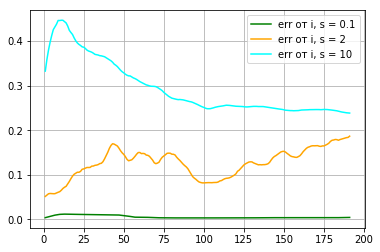

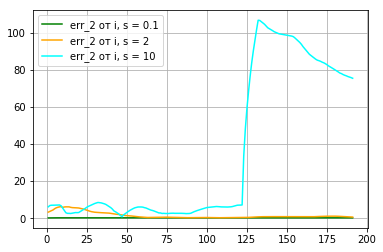

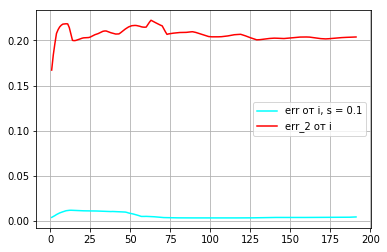

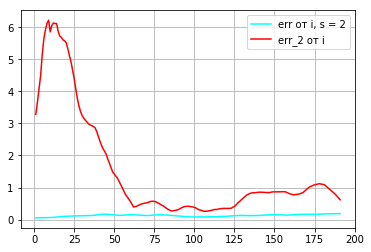

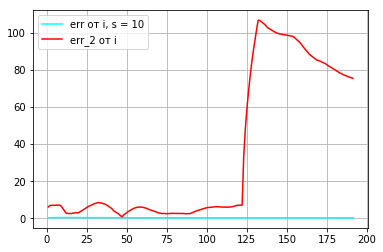

In [34]:
fig, ax = plt.subplots()  
i = np.linspace(1,N-9, N-9)

plt.plot(i, err_1, color="green", label="err от i, s = 0.1")
plt.plot(i, err_12, color="orange", label="err от i, s = 2")
plt.plot(i, err_13, color="cyan", label="err от i, s = 10")
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('plot1_200.pdf')

fig, ax = plt.subplots()
plt.plot(i, err_2, color="green", label="err_2 от i, s = 0.1")
plt.plot(i, err_22, color="orange", label="err_2 от i, s = 2")
plt.plot(i, err_23, color="cyan", label="err_2 от i, s = 10")
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('plot2_200.pdf')


fig, ax = plt.subplots()
plt.plot(i, err_1, color="cyan", label="err от i, s = 0.1")
plt.plot(i, err_2, color="red", label="err_2 от i")
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('plot11_200.pdf')

fig, ax = plt.subplots()
plt.plot(i, err_12, color="cyan", label="err от i, s = 2")
plt.plot(i, err_22, color="red", label="err_2 от i")
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('plot22_200.pdf')

fig, ax = plt.subplots()
plt.plot(i, err_13, color="cyan", label="err от i, s = 10")
plt.plot(i, err_23, color="red", label="err_2 от i")
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('plot33_200.pdf')